In [67]:
import scipy.io as sio
import math
import numpy as np
from matplotlib import pyplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [3]:
data = sio.loadmat('ex4/ex4data1.mat')

In [9]:
X, Y = data['X'], data['y'].ravel().reshape(-1,1)
m = Y.shape[0]

In [5]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

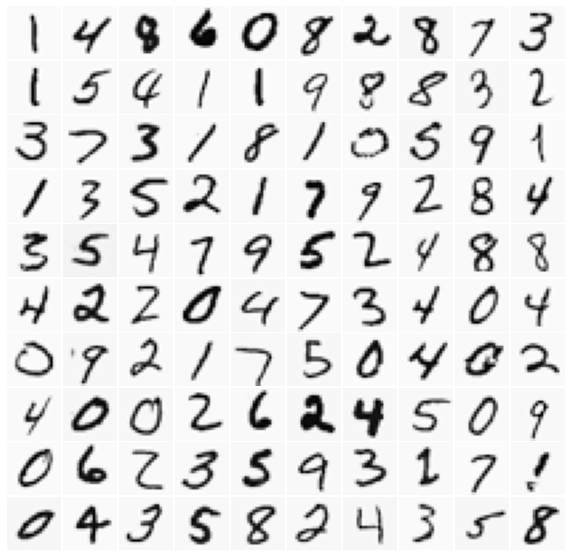

In [12]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
displayData(sel)

In [85]:
class NeuralNetwork:

    def __init__(self, input_layer_size, output_layer_size, hidden_layers, list_weights=None):
        self.input_layer_size = input_layer_size
        self.output_layer_size = output_layer_size
        self.hidden_layers = hidden_layers
        self.list_weights = list_weights if list_weights else self.initialize_weights()

    def initialize_weights(self):
        list_weights = []
        L_in = self.input_layer_size
        for L_out in self.hidden_layers:
            list_weights.append(self.rand_initialize_weights(L_in, L_out))
            L_in = L_out
        list_weights.append(self.rand_initialize_weights(L_in, self.output_layer_size))
        return list_weights

    def rand_initialize_weights(self, L_in, L_out):
        epsilon = math.sqrt(6) / math.sqrt(L_in + L_out)
        return np.random.uniform(-epsilon, epsilon, size=(L_out, L_in + 1))

    def feed_forward(self, features):
        activations = []
        bias_input = np.ones((features.shape[0], 1))
        activation = np.append(bias_input, features, axis=1)
        activations.append(activation)
        for weights in self.list_weights:
            activation = np.append(bias_input, self.sigmoid(np.dot(activation, weights.transpose())), axis=1)
            activations.append(activation)
        return activations
        # return activation[:, 1:]

    def get_hypothesis(self, features):
        return self.feed_forward(features)[-1][:, 1:]

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict(self, features):
        hypothesis = self.get_hypothesis(features)
        predicted_labels = (hypothesis == hypothesis.max(axis=1)[:, None]).astype(int)
        return predicted_labels
        # return np.argmax(self.feed_forward(features, list_weights), axis=1)

    def accuracy(self, true_labels, predicted_labels):
        return (np.sum(np.multiply(predicted_labels, true_labels)) / len(true_labels)) * 100

    def compute_cost(self, features, labels):
        m = len(labels)
        hypothesis = self.get_hypothesis(features)
        return -np.sum(np.sum(np.multiply(np.log(hypothesis), labels), axis=1) + np.sum(
            np.multiply(np.log(1 - hypothesis), 1 - labels), axis=1), axis=0) / m

    def compute_cost_reg(self, features, labels, lam):
        m = len(labels)
        cost = self.compute_cost(features, labels)
        for weights in self.list_weights:
            cost += lam * np.sum(np.multiply(
                np.append(np.zeros((weights.shape[0], 1)), np.ones((weights.shape[0], weights.shape[1] - 1)), axis=1),
                np.multiply(weights, weights))) / (2 * m)
        return cost

    def back_propagation(self, features, labels):
        m = len(labels)
        activations = self.feed_forward(features)
        hypothesis = activations[-1][:, 1:]
        delta = hypothesis - labels
        gradient_vector = self.initialize_gradient_vector()
        for i in range(len(self.hidden_layers), -1, -1):
            gradient_vector[i] = np.dot(delta.transpose(), activations[i])
            delta = np.multiply(np.dot(delta, self.list_weights[i]), np.multiply(activations[i], 1 - activations[i]))[:, 1:]
        return gradient_vector

    def regularization_descent(self, weights, lam):
        return lam * (np.multiply(
            np.append(np.zeros((weights.shape[0], 1)), np.ones((weights.shape[0], weights.shape[1] - 1)), axis=1),
            weights))

    def train(self, features, labels, iters, lam, lr):
        m = len(labels)
        cost_history = []
        for iteration in range(iters):
            gradient_vector = self.back_propagation(features, labels)
            for i in range(len(self.list_weights)):
                descent = gradient_vector[i] + self.regularization_descent(self.list_weights[i], lam)
                self.list_weights[i] = self.list_weights[i] - (lr / m) * descent
            cost = self.compute_cost_reg(features, labels, lam)
            cost_history.append([iteration, cost])
        return self.list_weights, cost_history

    def initialize_gradient_vector(self):
        gradient_vector = []
        for weights in self.list_weights:
            gradient_vector.append(np.zeros((weights.shape[0], weights.shape[1])))
        return gradient_vector


In [86]:
X, Y = data['X'], data['y'].ravel().reshape(-1, 1)
Y = Y-1
features = X
encoder = OneHotEncoder(sparse=False)
labels = encoder.fit_transform(Y)
weights = sio.loadmat('ex4/ex4weights.mat')
neural_network = NeuralNetwork(400, 10, [25])
list_weights, cost_history = neural_network.train(features, labels, 100, 0, 1)
predicted_labels = neural_network.predict(features)
print(neural_network.accuracy(labels, predicted_labels))
print(cost_history)

87.74
[[0, 3.742664210540046], [1, 3.3235875512086057], [2, 3.2166524620039905], [3, 3.170113116382766], [4, 3.136635215372261], [5, 3.1055666089086036], [6, 3.074013166080582], [7, 3.041174950139945], [8, 3.006832798728873], [9, 2.970966733164936], [10, 2.9336495813014656], [11, 2.8950040236931285], [12, 2.855182158317418], [13, 2.8143563550798745], [14, 2.772713746926822], [15, 2.730449895699187], [16, 2.6877604994928483], [17, 2.6448327077039595], [18, 2.601838779953442], [19, 2.5589336187995126], [20, 2.5162554487433364], [21, 2.4739277587362203], [22, 2.4320610161560303], [23, 2.3907536080841485], [24, 2.350092139047242], [25, 2.3101514585890692], [26, 2.2709947780967874], [27, 2.232674130607262], [28, 2.1952313054545627], [29, 2.1586992629421964], [30, 2.1231038895274947], [31, 2.088465786975104], [32, 2.054801637366956], [33, 2.022124651135667], [34, 1.9904438173782204], [35, 1.9597621648829984], [36, 1.930074796710712], [37, 1.901367686523115], [38, 1.8736178870291202], [39, 1.

In [87]:
cost_history[10]

[10, 2.9336495813014656]

In [88]:
len(labels)

5000

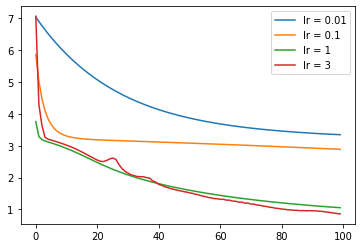

In [90]:
## Choosing learning rate
neural_network = NeuralNetwork(400, 10, [25])
list_weights, cost_history = neural_network.train(features, labels, 100, 0, 0.01)
plt.plot([cost_history[i][0] for i in range(len(cost_history))], [cost_history[i][1] for i in range(len(cost_history))], label = "lr = 0.01")
neural_network = NeuralNetwork(400, 10, [25])
list_weights, cost_history = neural_network.train(features, labels, 100, 0, 0.1)
plt.plot([cost_history[i][0] for i in range(len(cost_history))], [cost_history[i][1] for i in range(len(cost_history))], label = "lr = 0.1")
neural_network = NeuralNetwork(400, 10, [25])
list_weights, cost_history = neural_network.train(features, labels, 100, 0, 1)
plt.plot([cost_history[i][0] for i in range(len(cost_history))], [cost_history[i][1] for i in range(len(cost_history))], label = "lr = 1")
neural_network = NeuralNetwork(400, 10, [25])
list_weights, cost_history = neural_network.train(features, labels, 100, 0, 3)
plt.plot([cost_history[i][0] for i in range(len(cost_history))], [cost_history[i][1] for i in range(len(cost_history))], label = "lr = 3")
plt.legend()

99.46000000000001


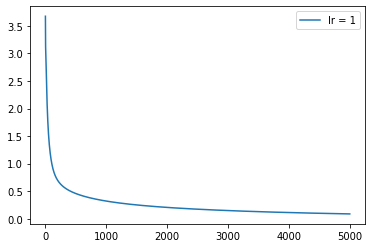

In [95]:
#Choosing learning rate 1
neural_network = NeuralNetwork(400, 10, [25])
list_weights, cost_history = neural_network.train(features, labels, 5000, 0, 1)
predicted_labels = neural_network.predict(features)
print(neural_network.accuracy(labels, predicted_labels))
plt.plot([cost_history[i][0] for i in range(len(cost_history))], [cost_history[i][1] for i in range(len(cost_history))], label = "lr = 1")
plt.legend()

98.82


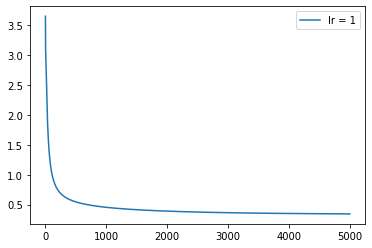

In [97]:
neural_network = NeuralNetwork(400, 10, [25])
list_weights, cost_history = neural_network.train(features, labels, 5000 , 1, 1)
predicted_labels = neural_network.predict(features)
print(neural_network.accuracy(labels, predicted_labels))
plt.plot([cost_history[i][0] for i in range(len(cost_history))], [cost_history[i][1] for i in range(len(cost_history))], label = "lr = 1")
plt.legend()